## **Tuning Convolutional Neural Networks Using Genetic Algorithms**


## By Neha Mittal 2020A3PS2324

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Pytorch and Numpy Packages

In [ ]:
import time
import cv2
import os
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, io, utils
from torch.utils.data import DataLoader
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from tqdm import tqdm 
import numpy as np
from PIL import Image
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Number of epochs is set to 5. Custom DataLoader to read images 



In [ ]:
num_classes = 2
num_epochs = 5

In [ ]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# preprocessing of images
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)


In [ ]:
img_files = os.listdir('/content/drive/MyDrive/genetic/data/train_ss')

img_files = list(filter(lambda x: x != 'train', img_files))

def train_path(p): return f"/content/drive/MyDrive/genetic/data/train_ss/{p}"

img_files = list(map(train_path, img_files))

print("total training images", len(img_files))

total training images 7369


In [ ]:
# create train-test split
random.shuffle(img_files)
random.shuffle(img_files)
train_images = img_files[:2000]

valid_images = img_files[2000:2500] 

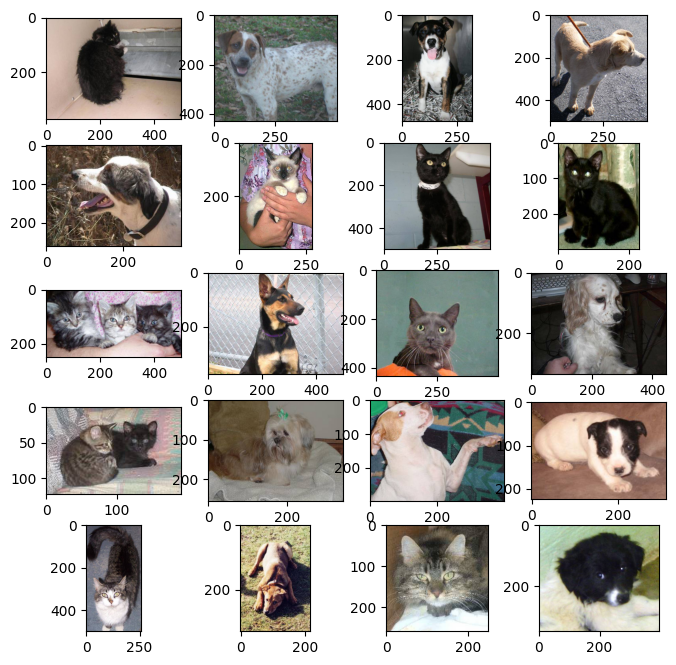

In [ ]:
import matplotlib.image as mpimg

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = mpimg.imread(img_files[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Convolutional Neural Network Class 

Consists of 


1.   3 Convolutional Layers
2.   2 Fully Connected Layers



In [ ]:
# Pytorch Convolutional Neural Network Model Architecture
class CatDogCNN(nn.Module):

    def __init__(self, oc1, oc2, oc3, ker1, ker2, ker3):
        super().__init__()

        # Convolutional layers (3,16,32)
        self.net = nn.Sequential(
              nn.Conv2d(in_channels = 3, out_channels = oc1, kernel_size=ker1, stride=2, padding=1),
              nn.MaxPool2d(2,2),
              nn.Conv2d(in_channels = oc1, out_channels = oc2, kernel_size=ker2, stride=2, padding=1),
              nn.MaxPool2d(2,2),
              nn.Conv2d(in_channels = oc2, out_channels = oc3, kernel_size=ker3, padding=1)
        )

        size = self.fcSize(224, ker1, ker2, ker3 )
        self.fc = nn.Sequential(
              # conected layers
              nn.Linear(in_features= oc3 *size*size, out_features=500),
              nn.Linear(in_features=500, out_features=50),
              nn.Linear(in_features=50, out_features=2)
        )


    def fcSize(self, width, ker1, ker2, ker3):

        size = int ((width + 2*1 - ker1)/(2)) + 1
        size = int (size/2)
        size = int ((size + 2*1 - ker2)/(2)) + 1
        size = int(size/2)
        size = int ((size + 2*1 - ker3)/1) + 1   
        return size

    def forward(self, X):

        X = self.net(X)
        X = X.view(X.shape[0], -1)
        X = self.fc(X)

        return X

# **Experiment 1**

In this experiment the CNN model is tuned/constructed

The configurations used for constructing CNN are 
---
1. Number of feature maps for Convolutional Layer 1 
2. Number of feature maps for Convolutional Layer 2
3. Number of feature maps for Convolutional Layer 3
4. Size of the kernel filter for layer 1
5. Size of the kernel filter for layer 2
6. Size of the kernel filter for layer 1

The configurations used for training CNN are 
---

1. Learning Rate 
2. Batch Size used for training the model

In [ ]:
# Set Loss function with criterion
criterionF = nn.CrossEntropyLoss()

##**Fitness** **Function**

The following section of the code trains and validates the trained model.  Custom data loader for CatDogDataset is used. 

Training the model requires the genetic algorithm to create the model and pass the model as parameter to this fitness function. 

In [ ]:
def train_and_validate(model,  optimizerF, fitness_scores, batch, pop_index, n_epochs):

  train_loss , train_accuracy = [], []
  val_loss , val_accuracy = [], []
  start = time.time()
  best_val_acc = 0.0
  best_train_acc = 0.0

  # create train dataset
  train_ds = CatDogDataset(train_images, transform)
  train_dl = DataLoader(train_ds, batch_size=batch)

  # create test dataset
  valid_ds = CatDogDataset(valid_images, transform)
  test_dl = DataLoader(valid_ds, batch_size=batch)

  for epoch in range(n_epochs):
      
      # print(f'Epoch {epoch} ....')
      train_epoch_loss, train_epoch_acc = train(model, train_dl, optimizerF)
      val_epoch_loss, val_epoch_acc = validate(model, test_dl)

      # print(f'Train Loss: {train_epoch_loss:.4f} Train Acc: {train_epoch_acc:.2f} Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.2f}')

      train_loss.append(train_epoch_loss)
      train_accuracy.append(train_epoch_acc)
      val_loss.append(val_epoch_loss)
      val_accuracy.append(val_epoch_acc)

  print(f"Accuracy for the population {pop_index} is {val_epoch_acc}")
  fitness_scores.append((pop_index, val_epoch_acc))

  del train_loss
  del val_loss
  end = time.time()
  print((end-start)/60, 'minutes')
  return fitness_scores

In [ ]:
def train(model, train_dataloader, optimizerF):

    model.train()
    accuracyF = []
    train_running_loss = 0.0
    total_count = 0
    total_correct = 0

    for X, y in train_dataloader:

        optimizerF.zero_grad()
        batch = X.to(device)
        labels = y.to(device)
        
        output = model(batch)

        loss = criterionF(output, labels)

        train_running_loss += loss.item()
        total_count += len(batch)
        _, preds = torch.max(output, 1)

        total_correct += torch.sum(preds == labels).sum().item()
        
        loss.backward()
        optimizerF.step()

        

    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * total_correct/len(train_dataloader.dataset)

    
    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader):

    val_running_loss = 0.0
    val_running_correct = 0

    total_correct = 0 
    model.eval()

    for test_X, test_y in val_loader:
        batch, labels = test_X.to(device), test_y.to(device)

        output = model(batch)
        loss = criterionF(output, labels)

        val_running_loss += loss.item()
        _, preds = torch.max(output, 1)
        total_correct += torch.sum(preds == labels).sum().item()
        

    val_loss = val_running_loss/len(val_loader.dataset)
    val_accuracy = 100. * total_correct/len(val_loader.dataset)
    
    return val_loss, val_accuracy

## **Genetic Algorithm Class**

This class is responsible for implementing the genetic algorithm for tuning the CNN Model

1.   **Fitness Function**: The fitness function trains the CNN Model for the configuration provided in each sample population. The fitness function uses the accuracy of prediction for comparing parents. 

2.   **sortParents**: This function sorts the parents on the basis of the fitness scores calculated in the previous step. 

3.   **Crossover**: This function is responsible for generating offsprings using crossover functionality. Since the various configurations of CNN are involved, so cross over is done only on the relevant sections of the configuration. For example, cross over of Number of filters/feature maps can't be done with size of the filters. Also, the cross over values should follow a specific order. We can't have a very large number of output channels at the first convolutional layer and a very small number of featuremaps/filters at the last layers.

4.   **Mutation**: Based on a randomy generated mutation rate, one configuration is randomly mutated from a set of values that configuration can take

5.   **Select Parents**: Select the top N/2 parents 
6.   **Process**: A wrapper function for execution the genetic algorithm in a proper sequence and reporting the results. 







In [ ]:
class CreateCNNModel:

  def __init__(self):
      self.initialize_population()
      self.acc_prev = -999
      self.acc = 0
      self.cnnModel = None

  def initialize_population(self):  
      self.population = np.array(
          [[ 8,  16,  128,   3,   3,   3, 0.0001,  64],
          [  8,  16,  128,   3,   3,   3, 0.001, 128],          
          [  8,  32,  256,   5,   3,   5, 0.01,  128],
          [  8,  32,  256,   5,   3,   5, 0.001, 256],
          [  8,  64,  512,   3,   3,   3, 0.001, 128],
          [  8,  64,  512,   3,   3,   3, 0.0001, 256],
          [  8,  16,  128,   5,   5,   3, 0.001,  128],
          [  8,  16,  128,   5,   5,   3, 0.0001, 256],
          [ 16,  128, 256,   3,   5,   5, 0.0001, 64],
          [ 16,  128, 256,   3,   5,   5, 0.001, 256],
          [ 16,  128, 512,   5,   5,   7, 0.01,  64],
          [ 16,  128, 512,   5,   5,   7, 0.001, 256],
          [ 16,  256, 512,   3,   3,   3, 0.0001, 128],
          [ 16,  256, 512,   3,   3,   3, 0.001, 256],
          [ 24,  64,  256,   3,   5,   7, 0.01,  64],
          [ 24,  64,  256,   3,   5,   7, 0.001, 256],
          [ 24,  128, 512,   5,   7,   3, 0.0001, 64],
          [ 24,  128, 512,   5,   7,   3, 0.001, 256],
          [ 24,  256, 512,   3,   3,   3, 0.01,  128],
          [ 24,  256, 512,   3,   3,   3, 0.001, 256],
          [ 32,  256, 512,   3,   5,   3, 0.01,  64],
          [ 32,  256, 512,   3,   5,   3, 0.001, 256],
          [ 32,  256, 1024,  5,   5,   5, 0.0001,  128],
          [ 32,  256, 1024,  5,   5,   5, 0.001, 64],
          [ 32,  512, 1024,  3,   3,   3, 0.0001,  256],
          [ 32,  512, 1024,  3,   3,   3, 0.001,  128],
          [ 48,  128, 1024,  3,   3,   3, 0.01,  128],
          [ 48,  128, 1024,  3,   3,   3, 0.001, 64],
          [ 48,  256, 1024,  3,   5,   7, 0.0001,  128],
          [ 48,  256, 1024,  3,   5,   7, 0.001, 256],
          [ 48,  512, 1024,  3,   3,   3, 0.0001,  128],
          [ 48,  512, 1024,  3,   3,   3, 0.001, 64]], dtype=object)

  def fitness(self, prev_fitness, attempts): 
      index = 0
      fitness_scores = []
      num_epochs = 3

      print(f'Number of epochs {num_epochs}')

      if len(prev_fitness) != 0:
            half_mark = int(self.population.shape[0]/2)

      else:
            half_mark = int(self.population.shape[0])
      print(f'Half Mark: {half_mark}')

      for conf in self.population:
          print(f"Finding the fitness for {conf} ")
          if index < half_mark :
              self.cnnModel = CatDogCNN(conf[0], conf[1], conf[2], conf[3], conf[4], conf[5]).to(device)
              optimizerF = optim.Adam(params=self.cnnModel.parameters(), lr=conf[6])
              fitness_scores = train_and_validate(self.cnnModel, optimizerF, fitness_scores, conf[7], index, num_epochs)
              index = index + 1
          else:
              break

      if len(prev_fitness) != 0:
  
            # These population configs were already tested in previous run
            for x in range(half_mark):
                  fitness_scores.append( (half_mark+x, (prev_fitness[x])[1]))

      return fitness_scores

  def sortParents(self, fitness_scores):
      fitness_scores.sort(key = lambda i: i[1], reverse = True)
      print(f"Fitness scores after sorting {fitness_scores}")
      return fitness_scores

  def crossover(self, parents):
   
      nchild = self.population.shape[0] - len(parents)
      nparents = len(parents)
      child = np.zeros((nchild, parents[0].shape[0]), object)

      for i in range(0, nchild, 2):
          first = i
          second = i+1

          co_point1 = 2
          co_point2 = 7

          child[first, :co_point1] = parents[first, :co_point1]
          child[second, :co_point1] = parents[second, :co_point1]

          child[first, co_point1:co_point2] = parents[second, co_point1:co_point2]
          child[second, co_point1:co_point2] = parents[first, co_point1:co_point2]     

          child[first, co_point2:] = parents[first, co_point2:]
          child[second, co_point2:] = parents[second, co_point2:]


      return child

  def mutation(self, parents):
    mutation_rate = 0.5
    for idx in range(len(parents)):
      if random.random() < mutation_rate:
        i = random.randint(0, 7)
        if i == 0:
        # mutate filter size, strides and kernels
          parents[idx][i] = random.choice([8, 16, 24, 32])
        elif i == 1:
          parents[idx][i] = random.choice([16, 32, 64, 128, 256, 512])
        elif i == 2:
          parents[idx][i] = random.choice([128, 256, 512, 1024])
        elif i == 3 or i == 4 or i == 5:
          parents[idx][i] = random.choice([3,5,7])
        elif i == 6:
        # mutate learning rate
          parents[idx][i] = random.choice([0.0001, 0.001, 0.01,0.0005])
        elif i == 7:
        # mutate number of filters
          parents[idx][i] = random.choice([64, 128, 256])
    return parents


  def select_parents(self, fitness_scores, max_parents):
      
      best_parents = np.empty((0,8), object) 

      for i in range(max_parents):
          row = self.population[(fitness_scores[i])[0]].reshape(1, -1)
          best_parents = np.append(best_parents, row, axis=0)
      return best_parents
    

  def process(self):

      fitness_scores = []
      reco = []
      print(f'Starting the geometric algorithm')
      print(f'Training Image size is {len(train_images)}')
      print(f'Validation Image size is {len(valid_images)}')      
      iter = 1  
      while self.acc - self.acc_prev > 0.25:
          print(f'**********************************')
          print(f'Iteration {iter}...')
          print(f'**********************************')
          fitness_scores = self.fitness(fitness_scores, iter)
          print(f'Length is {len(fitness_scores)}')
          print(f'Parent fitness scores {fitness_scores}') 
          fitness_scores = self.sortParents(fitness_scores)
          print(f'Fitness scores after sorting')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(fitness_scores)))

          self.acc_prev = self.acc
          self.acc = (fitness_scores[0])[1]

          best_parents = self.select_parents(fitness_scores, int(self.population.shape[0]/2))
          print("Parents selected based on fitness scores ")
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(best_parents)))


          print("About to start crossover ...")
          new_parents = self.crossover(best_parents)
          print('Population after crossover is ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(new_parents)))

          print("About to start mutation ...")
          new_parents_m = self.mutation(new_parents)
          print('New parents after crossover and mutation are ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(new_parents_m)))          

          self.population = np.append(new_parents_m, best_parents, axis=0)
          print('Population after crossover and mutation is ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(self.population)))          

          print('END OF ITERATION')
          reco = best_parents

          del self.cnnModel
          iter = iter + 1
  
      print('Best configuration is ')
      print('\n'.join('{}: {}'.format(*k) for k in enumerate(reco)))          

In [ ]:
model = CreateCNNModel()
model.process()

Starting the geometric algorithm
Training Image size is 2000
Validation Image size is 500
**********************************
Iteration 1...
**********************************
Number of epochs 3
Half Mark: 32
Finding the fitness for [8 16 128 3 3 3 0.0001 64] 
Accuracy for the population 0 is 65.0
4.065427108605703 minutes
Finding the fitness for [8 16 128 3 3 3 0.001 128] 
Accuracy for the population 1 is 65.6
1.0053031682968139 minutes
Finding the fitness for [8 32 256 5 3 5 0.01 128] 
Accuracy for the population 2 is 56.2
0.9788776238759359 minutes
Finding the fitness for [8 32 256 5 3 5 0.001 256] 
Accuracy for the population 3 is 64.8
0.9829496264457702 minutes
Finding the fitness for [8 64 512 3 3 3 0.001 128] 
Accuracy for the population 4 is 66.8
1.0159912943840026 minutes
Finding the fitness for [8 64 512 3 3 3 0.0001 256] 
Accuracy for the population 5 is 65.2
0.9956640680631001 minutes
Finding the fitness for [8 16 128 5 5 3 0.001 128] 
Accuracy for the population 6 is 67.8
1

# Train the model with configuration selected 

In [ ]:
def train_and_validate_after_selection(model,  optimizerF, batch, n_epochs):

  train_loss , train_accuracy = [], []
  val_loss , val_accuracy = [], []
  start = time.time()
  best_val_acc = 0.0
  best_train_acc = 0.0

  # create train dataset
  train_ds = CatDogDataset(train_images, transform)
  train_dl = DataLoader(train_ds, batch_size=batch)
  print(f'The number of images in training dataset is {len(train_ds)}')

  # create test dataset
  valid_ds = CatDogDataset(valid_images, transform)
  valid_dl = DataLoader(valid_ds, batch_size=batch)

  for epoch in range(n_epochs):
      train_epoch_loss, train_epoch_acc = train(model, train_dl, optimizerF)
      val_epoch_loss, val_epoch_acc = validate(model, valid_dl)

      if epoch%2 == 0:
        print(f'Epoch: {epoch} Train Loss: {train_epoch_loss:.4f} Train Acc: {train_epoch_acc:.2f} Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.2f}')

      train_loss.append(train_epoch_loss)
      train_accuracy.append(train_epoch_acc)
      val_loss.append(val_epoch_loss)
      val_accuracy.append(val_epoch_acc)

  print(f"Accuracy for the population is {val_epoch_acc}")

  del train_loss
  del val_loss
  end = time.time()
  print((end-start)/60, 'minutes')

  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label='train accuracy')
  plt.plot(val_accuracy, color='blue', label='validataion accuracy')
  plt.legend()
  plt.savefig('accuracy.png')
  plt.show()

The number of images in training dataset is 2000
Epoch: 0 Train Loss: 0.0073 Train Acc: 57.10 Validation Loss: 0.0054, Validation Acc: 63.00
Epoch: 2 Train Loss: 0.0042 Train Acc: 75.25 Validation Loss: 0.0050, Validation Acc: 66.40
Epoch: 4 Train Loss: 0.0035 Train Acc: 79.65 Validation Loss: 0.0049, Validation Acc: 67.20
Epoch: 6 Train Loss: 0.0028 Train Acc: 85.60 Validation Loss: 0.0052, Validation Acc: 68.40
Epoch: 8 Train Loss: 0.0020 Train Acc: 91.35 Validation Loss: 0.0059, Validation Acc: 68.20
Epoch: 10 Train Loss: 0.0012 Train Acc: 96.55 Validation Loss: 0.0074, Validation Acc: 67.00
Epoch: 12 Train Loss: 0.0011 Train Acc: 95.20 Validation Loss: 0.0087, Validation Acc: 67.60
Epoch: 14 Train Loss: 0.0009 Train Acc: 95.95 Validation Loss: 0.0094, Validation Acc: 65.20
Epoch: 16 Train Loss: 0.0015 Train Acc: 92.25 Validation Loss: 0.0126, Validation Acc: 65.40
Epoch: 18 Train Loss: 0.0008 Train Acc: 96.05 Validation Loss: 0.0114, Validation Acc: 64.20
Epoch: 20 Train Loss: 0.00

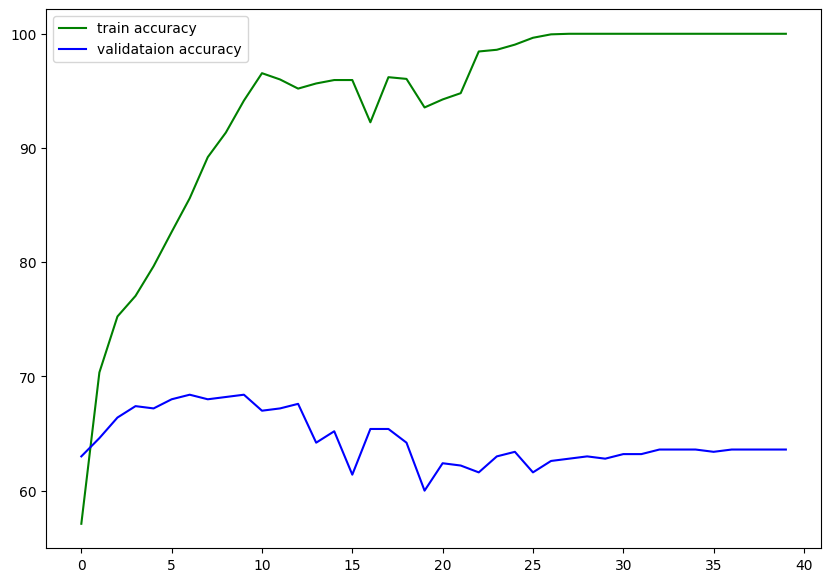

In [ ]:

cnnModel = CatDogCNN(16, 256, 1024, 3, 3, 3).to(device)
optimizerF = optim.Adam(params=cnnModel.parameters(), lr=0.0001)
train_and_validate_after_selection(cnnModel, optimizerF, 128, 40)

#**Experiment 2 - Convolutional and Fully Connected Layer Configurable**

In this experiment we try to construct/tune the CNN. We tune both the convolutional layer and the fully connected layer along with the training hyperparameters like learning rate and batch size. 

1.**Convolutional Layer - Number of filters**:  We have three layers in the basic CNN. So we have three configurations, one for each convolutionaly layer. This configuration provides the values of the number of filters/feature maps that should be for each convolutional layer. 

2.**Convolutional Layer - Size of filters**: For each convolutional layer besides knowing the number of filters, fixing the size of each filter for each of the convolutional layer is very important. There are three configurations one for each layer where we can specify the size of the filter for each layer. 

3.**Fully Connected Layer**: Each fully connected layer has a certain number of output features. This experiment provides configurations for the two fully connected layers which immediately follow the Convolutional Layer.

4.**Model Training Parameters**: These two parameters i.e learning rate and batch size are necessary to train the CNN effectively. Setting these parameters is very important. 



In [ ]:
# Pytorch Convolutional Neural Network Model Architecture
class DNNFC(nn.Module):

    def __init__(self, oc1, oc2, oc3, ker1, ker2, ker3, fcp1, fcp2):
        super().__init__()

        # Convolutional layers (3,16,32)
        self.net = nn.Sequential(
              nn.Conv2d(in_channels = 3, out_channels = oc1, kernel_size=ker1, stride=2, padding=1),
              nn.MaxPool2d(2,2),
              nn.Conv2d(in_channels = oc1, out_channels = oc2, kernel_size=ker2, stride=2, padding=1),
              nn.MaxPool2d(2,2),
              nn.Conv2d(in_channels = oc2, out_channels = oc3, kernel_size=ker3, padding=1)
        )

        size = self.fcSize(224, ker1, ker2, ker3 )
        self.fc = nn.Sequential(
              # conected layers
              nn.Linear(in_features= oc3 *size*size, out_features=fcp1),
              nn.Linear(in_features=fcp1, out_features=fcp2),
              nn.Linear(in_features=fcp2, out_features=2)
        )


    def fcSize(self, width, ker1, ker2, ker3):

        size = int ((width + 2*1 - ker1)/(2)) + 1
        size = int (size/2)
        size = int ((size + 2*1 - ker2)/(2)) + 1
        size = int(size/2)
        size = int ((size + 2*1 - ker3)/1) + 1   
        return size

    def forward(self, X):

        X = self.net(X)
        X = X.view(X.shape[0], -1)
        X = self.fc(X)

        return X

In [ ]:
class CreateCNNModelFC:

  def __init__(self):
      self.initialize_population()
      self.acc_prev = -999
      self.acc = 0
      self.dnnModel = None
      self.accuracy = []

  def initialize_population(self):  
      self.population = np.array(
          [[ 8,  16,  128,   3,   3,   3, 0.0001,  64, 2048, 256],
          [  8,  16,  128,   3,   3,   3, 0.001, 128, 1024, 512],          
          [  8,  32,  256,   5,   3,   5, 0.01,  128, 2048, 1024],
          [  8,  32,  256,   5,   3,   5, 0.001, 256, 1024, 256],
          [  8,  64,  512,   3,   3,   3, 0.001, 128, 2048, 1024],
          [  8,  64,  512,   3,   3,   3, 0.0001, 256, 1536, 512],
          [  8,  16,  128,   5,   5,   3, 0.001,  128, 1024, 128],
          [  8,  16,  128,   5,   5,   3, 0.0001, 256, 2048, 512],
          [ 16,  128, 256,   3,   5,   5, 0.0001, 64, 3072, 1024],
          [ 16,  128, 256,   3,   5,   5, 0.001, 256, 1024, 512],
          [ 16,  128, 512,   5,   5,   7, 0.01,  64, 4096, 512],
          [ 16,  128, 512,   5,   5,   7, 0.001, 256, 3072, 256],
          [ 16,  256, 512,   3,   3,   3, 0.0001, 128, 2048, 128],
          [ 16,  256, 512,   3,   3,   3, 0.001, 256, 1536, 1024],
          [ 24,  64,  256,   3,   5,   7, 0.01,  64, 4096, 512],
          [ 24,  64,  256,   3,   5,   7, 0.001, 256, 4096, 512],
          [ 24,  128, 512,   5,   7,   3, 0.0001, 64, 2048, 512],
          [ 24,  128, 512,   5,   7,   3, 0.001, 256, 1024, 512],
          [ 24,  256, 512,   3,   3,   3, 0.01,  128, 512, 128],
          [ 24,  256, 512,   3,   3,   3, 0.001, 256, 1024, 128],
          [ 32,  256, 512,   3,   5,   3, 0.01,  64, 1024, 512],
          [ 32,  256, 512,   3,   5,   3, 0.001, 256, 2048, 1024],
          [ 32,  256, 1024,  5,   5,   5, 0.0001,  128, 1024, 1024],
          [ 32,  256, 1024,  5,   5,   5, 0.001, 64, 2048, 512],
          [ 32,  512, 1024,  3,   3,   3, 0.0001,  256, 2048, 128],
          [ 32,  512, 1024,  3,   3,   3, 0.001,  128, 1536, 512],
          [ 48,  128, 1024,  3,   3,   3, 0.01,  128, 1024, 512],
          [ 48,  128, 1024,  3,   3,   3, 0.001, 64, 2048, 512],
          [ 48,  256, 1024,  3,   5,   7, 0.0001,  128, 1536, 128],
          [ 48,  256, 1024,  3,   5,   7, 0.001, 256, 1024, 512],
          [ 48,  512, 1024,  3,   3,   3, 0.0001,  128, 4096, 128],
          [ 48,  512, 1024,  3,   3,   3, 0.001, 64, 1536, 256]], dtype=object)

  def fitness(self, prev_fitness, attempts): 
      index = 0
      fitness_scores = []
      num_epochs = 5

      print(f'Number of epochs {num_epochs}')

      if len(prev_fitness) != 0:
            half_mark = int(self.population.shape[0]/2)

      else:
            half_mark = int(self.population.shape[0])
      print(f'Half Mark: {half_mark}')

      for conf in self.population:
          print(f"Finding the fitness for {conf} ")
          if index < half_mark :
              self.cnnModel = DNNFC(conf[0], conf[1], conf[2], conf[3], conf[4], conf[5], conf[8], conf[9]).to(device)
              optimizerF = optim.Adam(params=self.cnnModel.parameters(), lr=conf[6])
              fitness_scores = train_and_validate(self.cnnModel, optimizerF, fitness_scores, conf[7], index, num_epochs)
              index = index + 1
          else:
              break

      if len(prev_fitness) != 0:
  
            # These population configs were already tested in previous run
            for x in range(half_mark):
                  fitness_scores.append( (half_mark+x, (prev_fitness[x])[1]))

      return fitness_scores

  def sortParents(self, fitness_scores):
      fitness_scores.sort(key = lambda i: i[1], reverse = True)
      print(f"Fitness scores after sorting {fitness_scores}")
      return fitness_scores

  def crossover(self, parents):
   
      nchild = self.population.shape[0] - len(parents)
      nparents = len(parents)
      child = np.zeros((nchild, parents[0].shape[0]), object)

      for i in range(0, nchild, 2):
          first = i
          second = i+1

          co_point1 = 2
          co_point2 = 7

          child[first, :co_point1] = parents[first, :co_point1]
          child[second, :co_point1] = parents[second, :co_point1]

          child[first, co_point1:co_point2] = parents[second, co_point1:co_point2]
          child[second, co_point1:co_point2] = parents[first, co_point1:co_point2]     

          child[first, co_point2:] = parents[first, co_point2:]
          child[second, co_point2:] = parents[second, co_point2:]


      return child

  def mutation(self, parents):
    mutation_rate = 0.5
    for idx in range(len(parents)):
      if random.random() < mutation_rate:
        i = random.randint(0, 9)
        if i == 0:
        # mutate filter size, strides and kernels
          parents[idx][i] = random.choice([8, 16, 24, 32])
        elif i == 1:
          parents[idx][i] = random.choice([16, 32, 64, 128, 256, 512])
        elif i == 2:
          parents[idx][i] = random.choice([128, 256, 512, 1024])
        elif i == 3 or i == 4 or i == 5:
          parents[idx][i] = random.choice([3,5,7])
        elif i == 6:
        # mutate learning rate
          parents[idx][i] = random.choice([0.0001, 0.001, 0.01,0.0005])
        elif i == 7:
        # mutate number of filters
          parents[idx][i] = random.choice([64, 128, 256])
        elif i == 8:
          parents[idx][i] = random.choice([ 4096, 3072, 2560, 2048, 1536, 1024])
        elif i == 9:
          parents[idx][i] = random.choice([512, 256, 128])        
    return parents


  def select_parents(self, fitness_scores, max_parents):
      
      best_parents = np.empty((0,10), object) 

      for i in range(max_parents):
          row = self.population[(fitness_scores[i])[0]].reshape(1, -1)
          best_parents = np.append(best_parents, row, axis=0)
      return best_parents
    

  def process(self):

      fitness_scores = []
      reco = []
      print(f'Starting the geometric algorithm')
      print(f'Training Image size is {len(train_images)}')
      print(f'Validation Image size is {len(valid_images)}')      
      iter = 1  
      while self.acc - self.acc_prev > 0.25:
          print(f'**********************************')
          print(f'Iteration {iter}...')
          print(f'**********************************')
          fitness_scores = self.fitness(fitness_scores, iter)
          print(f'Length is {len(fitness_scores)}')
          print(f'Parent fitness scores {fitness_scores}') 
          fitness_scores = self.sortParents(fitness_scores)
          print(f'Fitness scores after sorting')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(fitness_scores)))

          self.acc_prev = self.acc
          self.acc = (fitness_scores[0])[1]

          best_parents = self.select_parents(fitness_scores, int(self.population.shape[0]/2))
          print("Parents selected based on fitness scores ")
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(best_parents)))


          print("About to start crossover ...")
          new_parents = self.crossover(best_parents)
          print('Population after crossover is ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(new_parents)))

          print("About to start mutation ...")
          new_parents_m = self.mutation(new_parents)
          print('New parents after crossover and mutation are ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(new_parents_m)))          

          self.population = np.append(new_parents_m, best_parents, axis=0)
          print('Population after crossover and mutation is ')
          print('\n'.join('{}: {}'.format(*k) for k in enumerate(self.population)))          

          print('END OF ITERATION')
          reco = best_parents

          torch.cuda.empty_cache()
          # del self.dnnModel
          iter = iter + 1

          self.accuracy.append(self.acc)
          
  
      print('Best configuration is ')
      print('\n'.join('{}: {}'.format(*k) for k in enumerate(reco))) 
      plt.figure(figsize=(7, 7))
      plt.plot(self.accuracy, color='green', label='train accuracy')
      plt.legend()
      plt.show()         

In [ ]:
modelFC = CreateCNNModelFC()
modelFC.process()

The number of images in training dataset is 2000
Epoch: 0 Train Loss: 0.0066 Train Acc: 53.45 Validation Loss: 0.0039, Validation Acc: 48.80
Epoch: 2 Train Loss: 0.0024 Train Acc: 66.35 Validation Loss: 0.0025, Validation Acc: 66.00
Epoch: 4 Train Loss: 0.0022 Train Acc: 72.10 Validation Loss: 0.0023, Validation Acc: 72.60
Epoch: 6 Train Loss: 0.0019 Train Acc: 77.20 Validation Loss: 0.0022, Validation Acc: 75.40
Epoch: 8 Train Loss: 0.0017 Train Acc: 81.15 Validation Loss: 0.0022, Validation Acc: 74.40
Epoch: 10 Train Loss: 0.0014 Train Acc: 85.70 Validation Loss: 0.0022, Validation Acc: 73.80
Epoch: 12 Train Loss: 0.0011 Train Acc: 90.20 Validation Loss: 0.0023, Validation Acc: 74.40
Epoch: 14 Train Loss: 0.0008 Train Acc: 93.40 Validation Loss: 0.0027, Validation Acc: 74.20
Epoch: 16 Train Loss: 0.0006 Train Acc: 95.30 Validation Loss: 0.0033, Validation Acc: 69.60
Epoch: 18 Train Loss: 0.0006 Train Acc: 93.40 Validation Loss: 0.0040, Validation Acc: 68.40
Epoch: 20 Train Loss: 0.00

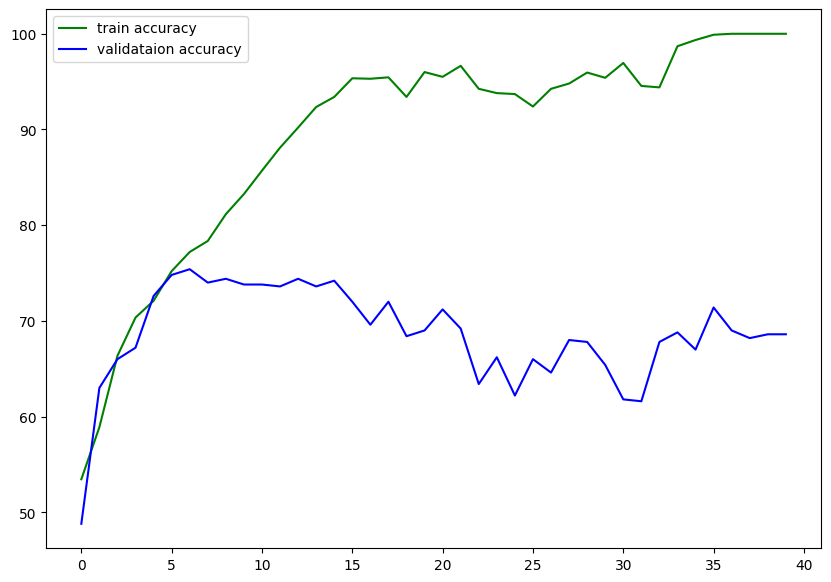

In [ ]:
myCnnModel = DNNFC(48, 512, 1024, 3, 3, 3,  2048, 128).to(device)
optimizerF = optim.Adam(params=myCnnModel.parameters(), lr=0.0001)
fitness_scores = train_and_validate_after_selection(myCnnModel, optimizerF, 256, 40)